# Finance Fundamental Concepts

## Sharpe Ratio

### <center>$\begin{split} S = \left( \frac{R_{p} - R_{f}}{\sigma_{p}} \right) \end{split}$</center>
#### <center>$\begin{split} \text{where } R_{p} &= \text{Expected Returns}\\
R_{f} &= \text{Risk Free Returns}\\
\sigma_{p} &= \text{Returns Standard Deviation}
\end{split}$</center>

**In general, the higher the Sharpe Ratio, the "better" the portfolio returns*

* Sharpe Ratio is based on a yearly basis, which does not work with a trading perspective
* $K$ factor is used to correct the Sharpe Ratio to different time windows
    * $K_{daily} = \sqrt{252}$
    * $K_{weekly} = \sqrt{52}$
    * $K_{monthly} = \sqrt{12}$
    * $S_{annualized} = K_{period} * S_{period}$

In [265]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl
from scipy.optimize import minimize

In [18]:
start_dt = datetime(2012, 1, 1)
end_dt = datetime(2017, 1, 1)

INIT_POSITION = 1000000

In [12]:
aapl = quandl.get('WIKI/AAPL.11', start_date=start_dt, end_date=end_dt)
cisco = quandl.get('WIKI/CSCO.11', start_date=start_dt, end_date=end_dt)
ibm = quandl.get('WIKI/IBM.11', start_date=start_dt, end_date=end_dt)
amzn = quandl.get('WIKI/AMZN.11', start_date=start_dt, end_date=end_dt)

In [19]:
for stock_df in (aapl, cisco, ibm, amzn):
    stock_df['Normed Return'] = stock_df['Adj. Close'] / stock_df.iloc[0]['Adj. Close']

# Portfolio Allocation: 30% aapl, 20% csco, 40% amzn, 10% ibm
for stock_df, allo in zip((aapl, cisco, ibm, amzn), (.3, .2, .1, .4)):
    stock_df['Allocation'] = stock_df['Normed Return'] * allo

for stock_df in (aapl, cisco, ibm, amzn):
    stock_df['Position'] = stock_df['Allocation'] * INIT_POSITION

In [42]:
aapl.head(3)

,Adj. Close,Normed Return,Allocation,Position
Date,,,,
2012-01-03,52.848787,1.000000,0.300000,300000.000000
2012-01-04,53.132802,1.005374,0.301612,301612.236461
2012-01-05,53.722681,1.016536,0.304961,304960.727573


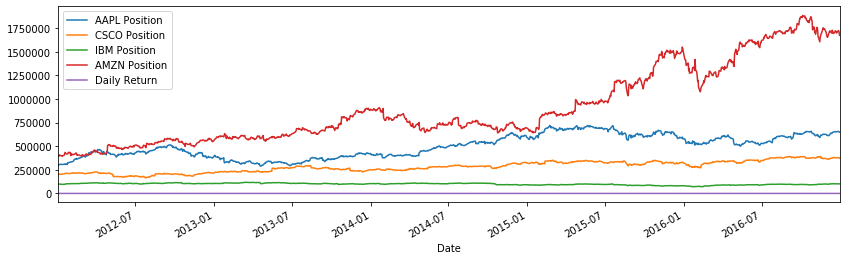

In [36]:
portfolio = pd.concat([aapl['Position'], cisco['Position'], ibm['Position'], amzn['Position']], axis=1)
portfolio.columns = ['AAPL Position', 'CSCO Position', 'IBM Position', 'AMZN Position']
portfolio['Total Position'] = portfolio.sum(axis=1)
portfolio['Daily Return'] = portfolio['Total Position'].pct_change(1)
portfolio.drop('Total Position', axis=1).plot(figsize=(14, 4));

Mean 0.0009023579071769599
Std 0.012896893878458078
Total Returns 179.97828220000912%


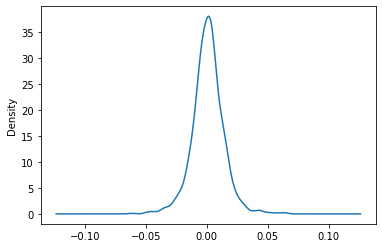

In [39]:
print('Mean', portfolio['Daily Return'].mean())
print('Std', portfolio['Daily Return'].std())
portfolio['Daily Return'].plot(kind='kde');
print('Total Returns {}%'.format(100 * (portfolio['Total Position'][-1] / portfolio['Total Position'][0] - 1)))

In [40]:
sr_daily = portfolio['Daily Return'].mean() / portfolio['Daily Return'].std()
sr_annual = (252 ** 0.5) * sr_daily
sr_annual

1.1106928405221748

## Portfolio Optimization
* Using Monte Carlo simulation
* Using optimization techniques
* Usage of Log returns => $\log r = \log\frac{p_{t}}{p_{t-1}}$

In [50]:
stocks = pd.concat([aapl['Adj. Close'], cisco['Adj. Close'], ibm['Adj. Close'], amzn['Adj. Close']], axis=1)
stocks.columns = ['AAPL', 'CSCO', 'IBM', 'AMZN']
stocks.pct_change(1).corr()

,AAPL,CSCO,IBM,AMZN
AAPL,1.000000,0.301990,0.297498,0.235487
CSCO,0.301990,1.000000,0.424672,0.284470
IBM,0.297498,0.424672,1.000000,0.258492
AMZN,0.235487,0.284470,0.258492,1.000000


AAPL    0.000614
CSCO    0.000497
IBM     0.000011
AMZN    0.001139
dtype: float64


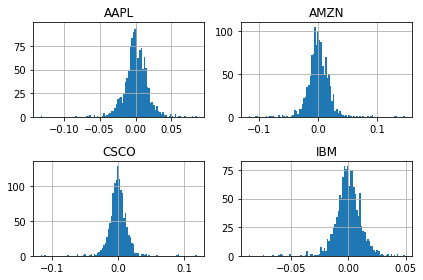

In [53]:
log_returns = np.log(stocks/stocks.shift(1))
log_returns.hist(bins=100);
plt.tight_layout()
print(log_returns.mean())

### Monte Carlo Simulations

In [254]:
%%time
# Monte Carlo simulations
np.random.seed(101)
n_portfolios = 5000
weights_arr = np.zeros((n_portfolios, len(stocks.columns)))
er_arr = np.zeros(n_portfolios)
ev_arr = np.zeros(n_portfolios)
sr_arr = np.zeros(n_portfolios)

for i in range(n_portfolios):
    weights = np.random.random(4)
    weights = weights / weights.sum()
    
    weights_arr[i, :] = weights

    expected_returns = (log_returns.mean() * weights * 252).sum()
    expected_volatility = np.sqrt(np.dot(weights, np.dot(log_returns.cov() * 252, weights)))

    sr = expected_returns / expected_volatility
    
    er_arr[i] = expected_returns
    ev_arr[i] = expected_volatility
    sr_arr[i] = sr

Wall time: 14.7 s


Optimal Portfolio:  [0.26188068 0.20759516 0.00110226 0.5294219 ]
Optimal SR:  1.0303260551271305


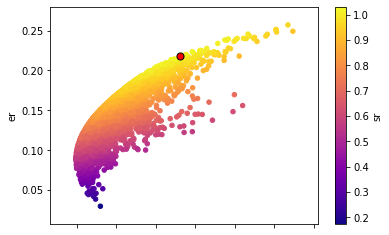

In [259]:
pd.DataFrame({'er': er_arr, 'ev': ev_arr, 'sr': sr_arr}).plot(kind='scatter', x='ev', y='er', c='sr', cmap='plasma');
plt.scatter(ev_arr[sr_arr.argmax()], er_arr[sr_arr.argmax()], c='r', s=50, edgecolors='black')
print('Optimal Portfolio: ', weights_arr[sr_arr.argmax()])
print('Optimal SR: ', sr_arr.max())

### Optimization Function in Scipy

In [272]:
# Optimizing weights, functions/objects to be used centred around weights concept
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    returns = np.sum(log_returns.mean() * weights) * 252
    volatilities = np.sqrt(np.dot(weights, np.dot(log_returns.cov() * 252, weights)))
    sr = returns / volatilities
    return np.array([returns, volatilities, sr])

def neg_sr(weights):
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    return np.sum(weights) - 1

constraints = ({'type':'eq', 'fun': check_sum})  # weights constraints of check_sum(weights) == 0 (or sum(weights) = 1)
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))  # bounds for weights
init_guess = [0.25, 0.25, 0.25, 0.25]  # initial weights guess

opt_results = minimize(fun=neg_sr, x0=init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
print(opt_results)
print('Optimal Results: {}'.format(get_ret_vol_sr(opt_results.x)))

     fun: -1.0307168703349403
     jac: array([ 5.64306974e-05,  4.18424606e-05,  3.39921713e-01, -4.45097685e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.26628977, 0.20418982, 0.        , 0.5295204 ])
Optimal Results: [0.21885915 0.21233683 1.03071687]


### Plotting the Optimal Portfolio Frontier (akin to PPC in Econs)